In [6]:
# Ячейка 1: Импорт библиотек и настройка
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append('../src')

from database import load_corrosion_data

# Настройки визуализации
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Библиотеки загружены")

Библиотеки загружены


In [7]:
# Ячейка 2: Загрузка и предварительный просмотр данных
df = load_corrosion_data()
print(f"📊 Загружено записей: {len(df)}")

# Покажем доступные химические колонки
chemical_columns = [col for col in df.columns if 'content' in col or 'total_' in col]
print(f"Химические параметры ({len(chemical_columns)}):")
for i, col in enumerate(chemical_columns):
    print(f"  {i+1:2d}. {col}")

df[['corrosion_rate'] + chemical_columns[:5]].head(3)

📊 Загружено записей: 442052
Химические параметры (38):
   1. water_content
   2. h2s_content
   3. sulfur_content
   4. chlorine_content
   5. co2_content
   6. oxygen_content
   7. nitrogen_content
   8. hydrogen_content
   9. methane_content
  10. ethane_content
  11. propane_content
  12. butane_content
  13. isobutane_content
  14. pentane_content
  15. isopentane_content
  16. gasoline_c6_c8_content
  17. hexane_content
  18. heavy_naphtha_content
  19. kerosene_content
  20. diesel_content
  21. residues_content
  22. propylene_content
  23. ethylene_content
  24. butylene_content
  25. sulfuric_acid_content
  26. hydrochloric_acid_content
  27. acetic_acid_content
  28. naphthenic_acid_content
  29. ammonia_content
  30. ammonium_content
  31. hydrogen_fluoride_content
  32. sodium_hydroxide_content
  33. corrosion_inhibitor_content
  34. total_components
  35. total_composition
  36. total_sulfur_compounds
  37. total_chlorine_compounds
  38. total_acids


,corrosion_rate,water_content,h2s_content,sulfur_content,chlorine_content,co2_content
0,NaN,0.5941,0.002,1.96,NaN,NaN
1,0.237175,0.5941,0.002,1.96,NaN,NaN
2,NaN,0.5941,0.002,1.96,NaN,NaN


In [9]:
# Очистка данных
print("ОЧИСТКА ДАННЫХ")

# Удаляем записи без скорости коррозии
initial_count = len(df)
df_clean = df[df['corrosion_rate'].notna()].copy()
print(f"Удалено записей без скорости коррозии: {initial_count - len(df_clean)}")

# Удаляем выбросы
df_clean = df_clean[df_clean['corrosion_rate'] <= 10]
df_clean = df_clean[df_clean['corrosion_rate'] >= 0]
print(f"Удалено выбросов: {initial_count - len(df_clean)}")
print(f"Итоговый размер данных: {len(df_clean)} записей")

# Заполняем пропуски в химических компонентах
for col in chemical_columns:
    df_clean[col] = df_clean[col].fillna(0)

print("Данные очищены и готовы для анализа")

ОЧИСТКА ДАННЫХ
Удалено записей без скорости коррозии: 128859
Удалено выбросов: 128920
Итоговый размер данных: 313132 записей
Данные очищены и готовы для анализа


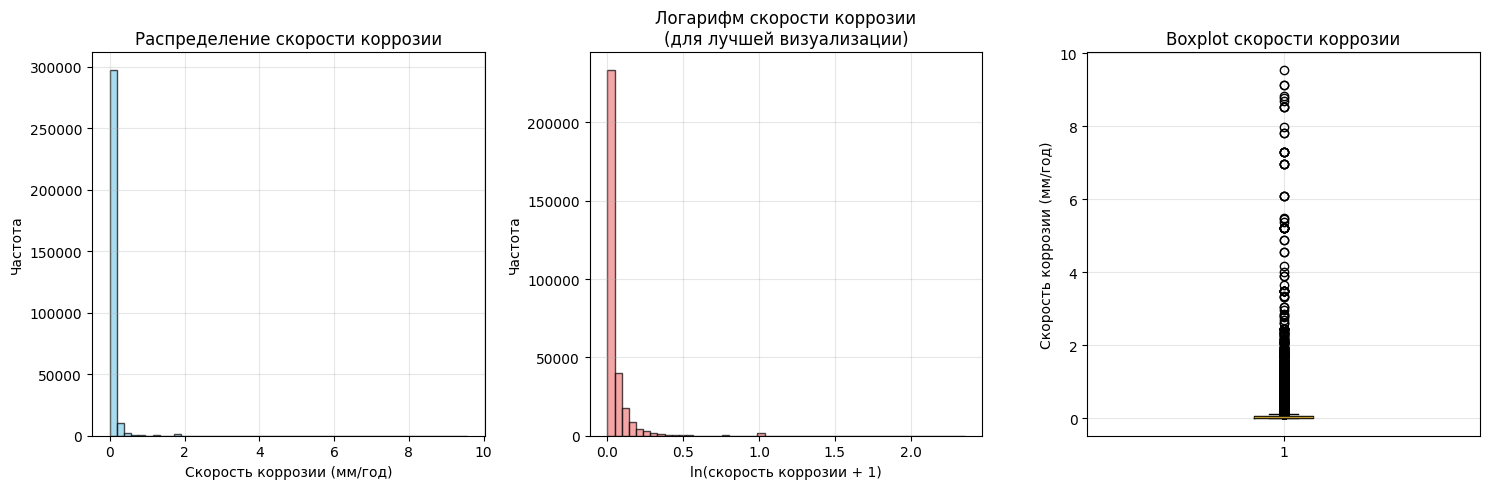

📊 Статистика скорости коррозии:
count    313132.000000
mean          0.054000
std           0.172428
min           0.000000
25%           0.000000
50%           0.024949
75%           0.049898
max           9.550707
Name: corrosion_rate, dtype: float64


In [10]:
# Анализ распределения скорости коррозии
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_clean['corrosion_rate'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.title('Распределение скорости коррозии')
plt.xlabel('Скорость коррозии (мм/год)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
corrosion_log = np.log1p(df_clean['corrosion_rate'])
plt.hist(corrosion_log, bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
plt.title('Логарифм скорости коррозии\n(для лучшей визуализации)')
plt.xlabel('ln(скорость коррозии + 1)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.boxplot(df_clean['corrosion_rate'])
plt.title('Boxplot скорости коррозии')
plt.ylabel('Скорость коррозии (мм/год)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Статистика скорости коррозии:")
print(df_clean['corrosion_rate'].describe())

In [11]:
# Ячейка 5: Выбор ключевых параметров для анализа
# Группируем параметры по категориям
parameter_groups = {
    'Основные коррозионные агенты': [
        'corrosion_rate', 'water_content', 'h2s_content', 'sulfur_content', 
        'chlorine_content', 'co2_content', 'oxygen_content'
    ],
    'Углеводороды легкие': [
        'methane_content', 'ethane_content', 'propane_content', 
        'butane_content', 'isobutane_content'
    ],
    'Углеводороды тяжелые': [
        'pentane_content', 'gasoline_c6_c8_content', 'heavy_naphtha_content',
        'kerosene_content', 'diesel_content', 'residues_content'
    ],
    'Непредельные и кислоты': [
        'propylene_content', 'ethylene_content', 'sulfuric_acid_content',
        'hydrochloric_acid_content', 'acetic_acid_content', 'naphthenic_acid_content'
    ],
    'Прочие параметры': [
        'nitrogen_content', 'hydrogen_content', 'ammonia_content',
        'corrosion_inhibitor_content', 'operating_temperature', 'operating_pressure'
    ],
    'Агрегатные показатели': [
        'total_sulfur_compounds', 'total_chlorine_compounds', 'total_acids',
        'total_components', 'total_composition'
    ]
}

print("ГРУППЫ ПАРАМЕТРОВ ДЛЯ АНАЛИЗА:")
for group_name, params in parameter_groups.items():
    print(f"  {group_name}: {len(params)} параметров")

ГРУППЫ ПАРАМЕТРОВ ДЛЯ АНАЛИЗА:
  Основные коррозионные агенты: 7 параметров
  Углеводороды легкие: 5 параметров
  Углеводороды тяжелые: 6 параметров
  Непредельные и кислоты: 6 параметров
  Прочие параметры: 6 параметров
  Агрегатные показатели: 5 параметров


In [12]:
# Ячейка 6: Общая матрица корреляций для топ-20 параметров
# Выбираем все числовые параметры кроме ID
numeric_columns = [
    'corrosion_rate', 'water_content', 'h2s_content', 'sulfur_content',
    'chlorine_content', 'co2_content', 'oxygen_content', 'nitrogen_content',
    'hydrogen_content', 'methane_content', 'ethane_content', 'propane_content',
    'butane_content', 'propylene_content', 'ethylene_content', 
    'sulfuric_acid_content', 'hydrochloric_acid_content', 
    'total_sulfur_compounds', 'total_chlorine_compounds', 'total_acids',
    'operating_temperature', 'operating_pressure'
]

# Ограничиваемся параметрами, которые есть в данных
available_columns = [col for col in numeric_columns if col in df_clean.columns]
corr_matrix = df_clean[available_columns].corr()

print("РАСЧЕТ МАТРИЦЫ КОРРЕЛЯЦИЙ")

РАСЧЕТ МАТРИЦЫ КОРРЕЛЯЦИЙ


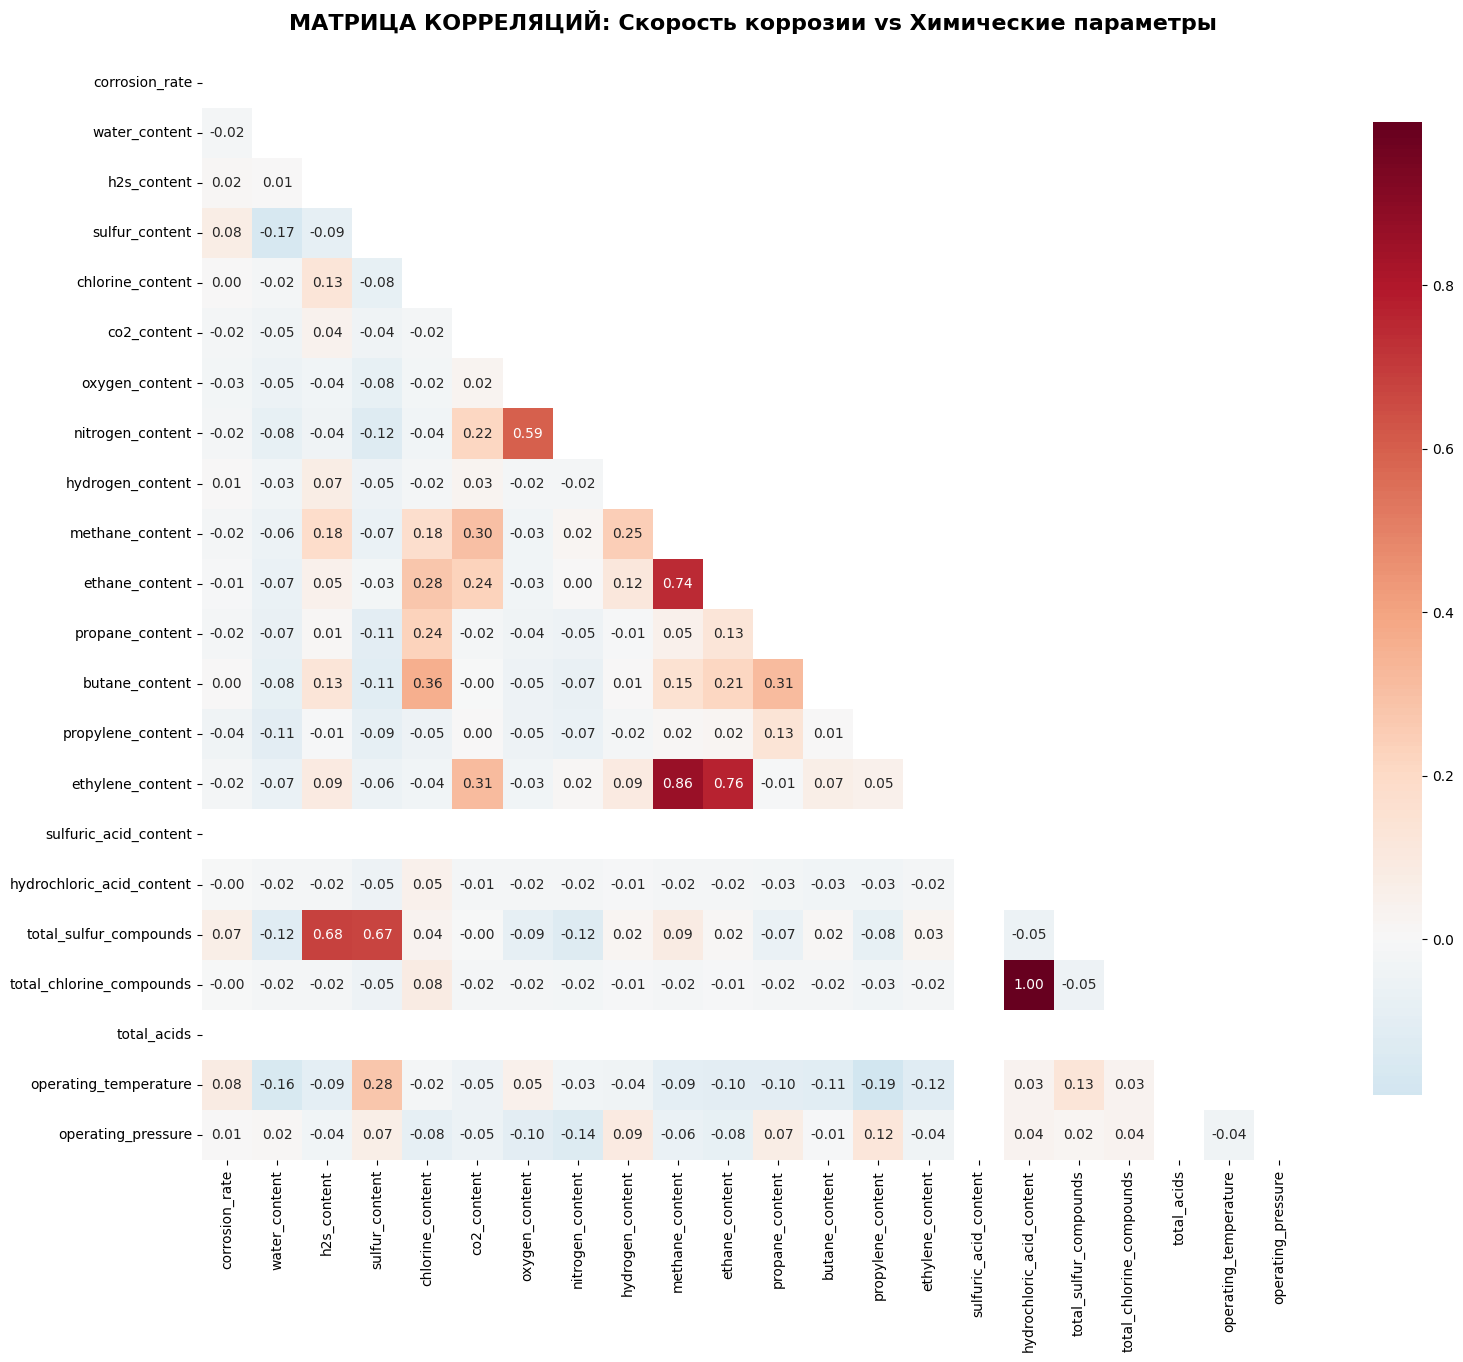

In [19]:
# Ячейка 7: Визуализация общей матрицы корреляций
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
           mask=mask,
           annot=True, 
           cmap='RdBu_r', 
           center=0,
           fmt='.2f',
           square=True,
           cbar_kws={'shrink': 0.8})

plt.title('МАТРИЦА КОРРЕЛЯЦИЙ: Скорость коррозии vs Химические параметры', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [20]:
# Ячейка 8: Топ коррелирующих факторов
corrosion_correlations = corr_matrix['corrosion_rate'].sort_values(ascending=False)

print("ТОП-20 ФАКТОРОВ ПО КОРРЕЛЯЦИИ С КОРРОЗИЕЙ:")
print("=" * 60)

# Преобразуем в список для индексации
corr_items = list(corrosion_correlations.items())[:21]

for i, (factor, corr) in enumerate(corr_items):
    if factor != 'corrosion_rate':
        stars = "***" if abs(corr) > 0.3 else "**" if abs(corr) > 0.2 else "*" if abs(corr) > 0.1 else ""
        direction = "ПОЛОЖИТЕЛЬНАЯ" if corr > 0 else "ОТРИЦАТЕЛЬНАЯ"
        print(f"{i:2d}. {factor:25} : {corr:+.4f} {stars} {direction}")

print("\nИНТЕРПРЕТАЦИЯ КОРРЕЛЯЦИЙ:")
print("  *** : Сильная корреляция (> 0.3)")
print("  **  : Средняя корреляция (0.2 - 0.3)") 
print("  *   : Слабая корреляция (0.1 - 0.2)")

ТОП-20 ФАКТОРОВ ПО КОРРЕЛЯЦИИ С КОРРОЗИЕЙ:
 1. operating_temperature     : +0.0817  ПОЛОЖИТЕЛЬНАЯ
 2. sulfur_content            : +0.0762  ПОЛОЖИТЕЛЬНАЯ
 3. total_sulfur_compounds    : +0.0687  ПОЛОЖИТЕЛЬНАЯ
 4. h2s_content               : +0.0170  ПОЛОЖИТЕЛЬНАЯ
 5. hydrogen_content          : +0.0084  ПОЛОЖИТЕЛЬНАЯ
 6. operating_pressure        : +0.0068  ПОЛОЖИТЕЛЬНАЯ
 7. butane_content            : +0.0021  ПОЛОЖИТЕЛЬНАЯ
 8. chlorine_content          : +0.0020  ПОЛОЖИТЕЛЬНАЯ
 9. total_chlorine_compounds  : -0.0033  ОТРИЦАТЕЛЬНАЯ
10. hydrochloric_acid_content : -0.0034  ОТРИЦАТЕЛЬНАЯ
11. ethane_content            : -0.0140  ОТРИЦАТЕЛЬНАЯ
12. propane_content           : -0.0155  ОТРИЦАТЕЛЬНАЯ
13. methane_content           : -0.0160  ОТРИЦАТЕЛЬНАЯ
14. co2_content               : -0.0187  ОТРИЦАТЕЛЬНАЯ
15. water_content             : -0.0198  ОТРИЦАТЕЛЬНАЯ
16. ethylene_content          : -0.0214  ОТРИЦАТЕЛЬНАЯ
17. nitrogen_content          : -0.0234  ОТРИЦАТЕЛЬНАЯ
18. oxygen_content    

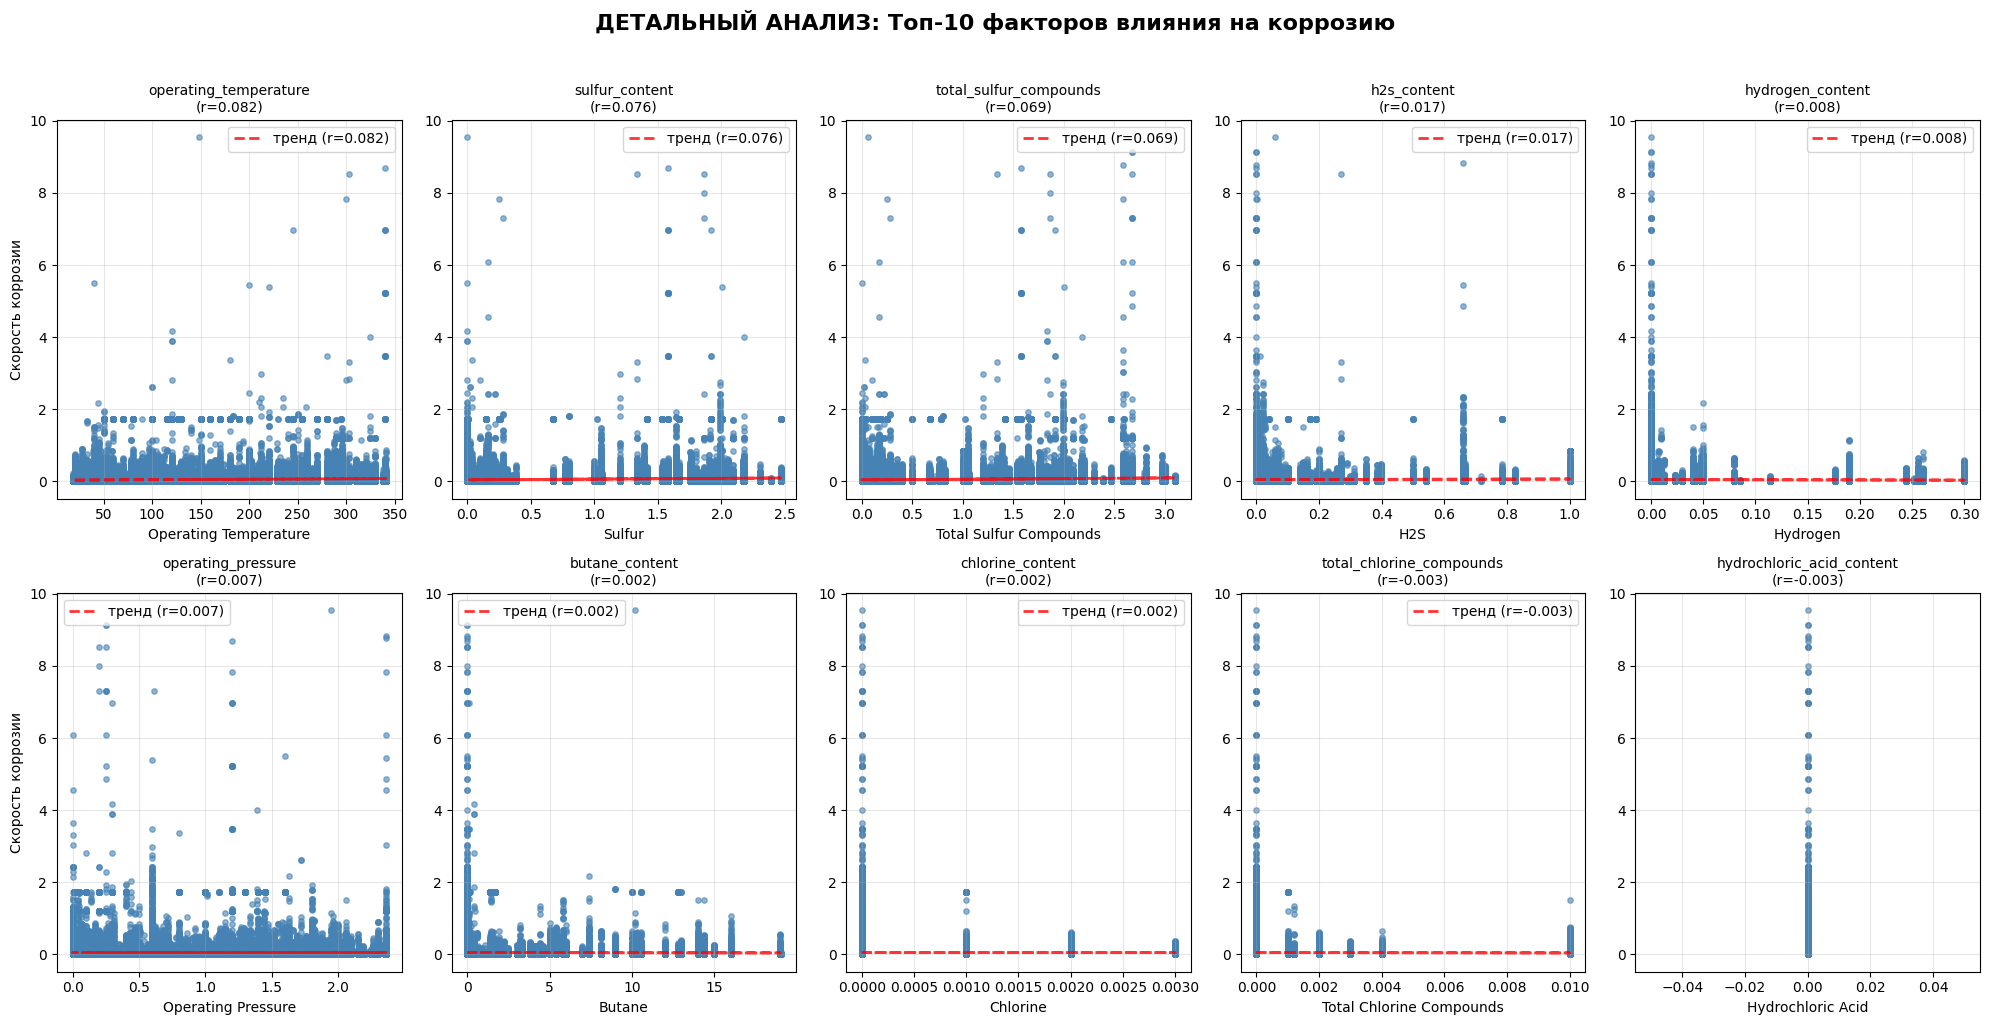

In [21]:
# Ячейка 9: Детальный анализ топ-10 факторов
top_factors = list(corrosion_correlations.index[1:11])  # Топ-10 кроме самой corrosion_rate

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

for i, factor in enumerate(top_factors):
    if i < len(axes):
        # Убираем выбросы для лучшей визуализации
        data_subset = df_clean[df_clean[factor] <= df_clean[factor].quantile(0.95)]
        
        axes[i].scatter(data_subset[factor], data_subset['corrosion_rate'], 
                       alpha=0.6, s=15, color='steelblue')
        
        # Линия тренда
        if len(data_subset[factor].unique()) > 1:
            z = np.polyfit(data_subset[factor], data_subset['corrosion_rate'], 1)
            p = np.poly1d(z)
            corr_value = corrosion_correlations[factor]
            axes[i].plot(data_subset[factor], p(data_subset[factor]), "r--", 
                        linewidth=2, alpha=0.8, label=f'тренд (r={corr_value:.3f})')
            axes[i].legend()
        
        axes[i].set_xlabel(factor.replace('_content', '').replace('_', ' ').title())
        axes[i].set_ylabel('Скорость коррозии' if i % 5 == 0 else '')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_title(f'{factor}\n(r={corr_value:.3f})', fontsize=10)

# Убираем лишние subplots
for i in range(len(top_factors), len(axes)):
    fig.delaxes(axes[i])
    
plt.suptitle('ДЕТАЛЬНЫЙ АНАЛИЗ: Топ-10 факторов влияния на коррозию', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [25]:
# Ячейка 10: Анализ по группам параметров
print("КОРРЕЛЯЦИИ ПО ГРУППАМ ПАРАМЕТРОВ:")
print("=" * 70)

# Сначала проверим, какие параметры реально существуют в данных
print("ПРОВЕРКА ДОСТУПНЫХ ПАРАМЕТРОВ:")
all_available_params = [col for col in df_clean.columns if col in corrosion_correlations.index and col != 'corrosion_rate']
print(f"Всего доступных параметров для анализа: {len(all_available_params)}")

# Создадим безопасные группы параметров
safe_parameter_groups = {
    'Основные коррозионные агенты': [
        'water_content', 'h2s_content', 'sulfur_content', 
        'chlorine_content', 'co2_content', 'oxygen_content'
    ],
    'Операционные параметры': [
        'operating_temperature', 'operating_pressure'
    ],
    'Газовые компоненты': [
        'nitrogen_content', 'hydrogen_content', 'methane_content'
    ],
    'Агрегатные показатели': [
        'total_sulfur_compounds', 'total_chlorine_compounds', 'total_acids'
    ]
}

# Фильтруем группы, оставляя только существующие параметры
actual_groups = {}
for group_name, params in safe_parameter_groups.items():
    available_in_group = [p for p in params if p in all_available_params]
    if available_in_group:
        actual_groups[group_name] = available_in_group

# Анализируем существующие группы
for group_name, params in actual_groups.items():
    try:
        group_correlations = corrosion_correlations[params].sort_values(ascending=False)
        
        print(f"\n{group_name.upper()} ({len(group_correlations)} параметров):")
        print("-" * 50)
        
        for param, corr in group_correlations.items():
            significance = "ВЫСОКАЯ" if abs(corr) > 0.3 else "СРЕДНЯЯ" if abs(corr) > 0.2 else "СЛАБАЯ" if abs(corr) > 0.1 else "ОЧЕНЬ СЛАБАЯ"
            direction = "↑" if corr > 0 else "↓"
            print(f"  {direction} {param:25} : {corr:+.4f} ({significance})")
    except KeyError as e:
        print(f"Ошибка в группе {group_name}: {e}")
        continue

# Дополнительно: покажем топ-15 всех параметров
print(f"\nТОП-15 ВСЕХ ПАРАМЕТРОВ ПО КОРРЕЛЯЦИИ:")
print("-" * 50)
top_15_all = list(corrosion_correlations.items())[1:16]  # Пропускаем саму corrosion_rate

for i, (param, corr) in enumerate(top_15_all, 1):
    significance = "ВЫСОКАЯ" if abs(corr) > 0.3 else "СРЕДНЯЯ" if abs(corr) > 0.2 else "СЛАБАЯ" if abs(corr) > 0.1 else "ОЧЕНЬ СЛАБАЯ"
    direction = "↑" if corr > 0 else "↓"
    print(f"  {i:2d}. {direction} {param:30} : {corr:+.4f} ({significance})")

КОРРЕЛЯЦИИ ПО ГРУППАМ ПАРАМЕТРОВ:
ПРОВЕРКА ДОСТУПНЫХ ПАРАМЕТРОВ:
Всего доступных параметров для анализа: 21

ОСНОВНЫЕ КОРРОЗИОННЫЕ АГЕНТЫ (6 параметров):
--------------------------------------------------
  ↑ sulfur_content            : +0.0762 (ОЧЕНЬ СЛАБАЯ)
  ↑ h2s_content               : +0.0170 (ОЧЕНЬ СЛАБАЯ)
  ↑ chlorine_content          : +0.0020 (ОЧЕНЬ СЛАБАЯ)
  ↓ co2_content               : -0.0187 (ОЧЕНЬ СЛАБАЯ)
  ↓ water_content             : -0.0198 (ОЧЕНЬ СЛАБАЯ)
  ↓ oxygen_content            : -0.0272 (ОЧЕНЬ СЛАБАЯ)

ОПЕРАЦИОННЫЕ ПАРАМЕТРЫ (2 параметров):
--------------------------------------------------
  ↑ operating_temperature     : +0.0817 (ОЧЕНЬ СЛАБАЯ)
  ↑ operating_pressure        : +0.0068 (ОЧЕНЬ СЛАБАЯ)

ГАЗОВЫЕ КОМПОНЕНТЫ (3 параметров):
--------------------------------------------------
  ↑ hydrogen_content          : +0.0084 (ОЧЕНЬ СЛАБАЯ)
  ↓ methane_content           : -0.0160 (ОЧЕНЬ СЛАБАЯ)
  ↓ nitrogen_content          : -0.0234 (ОЧЕНЬ СЛАБАЯ)

АГРЕГАТНЫЕ 

АНАЛИЗ ПАРНЫХ ВЗАИМОДЕЙСТВИЙ:


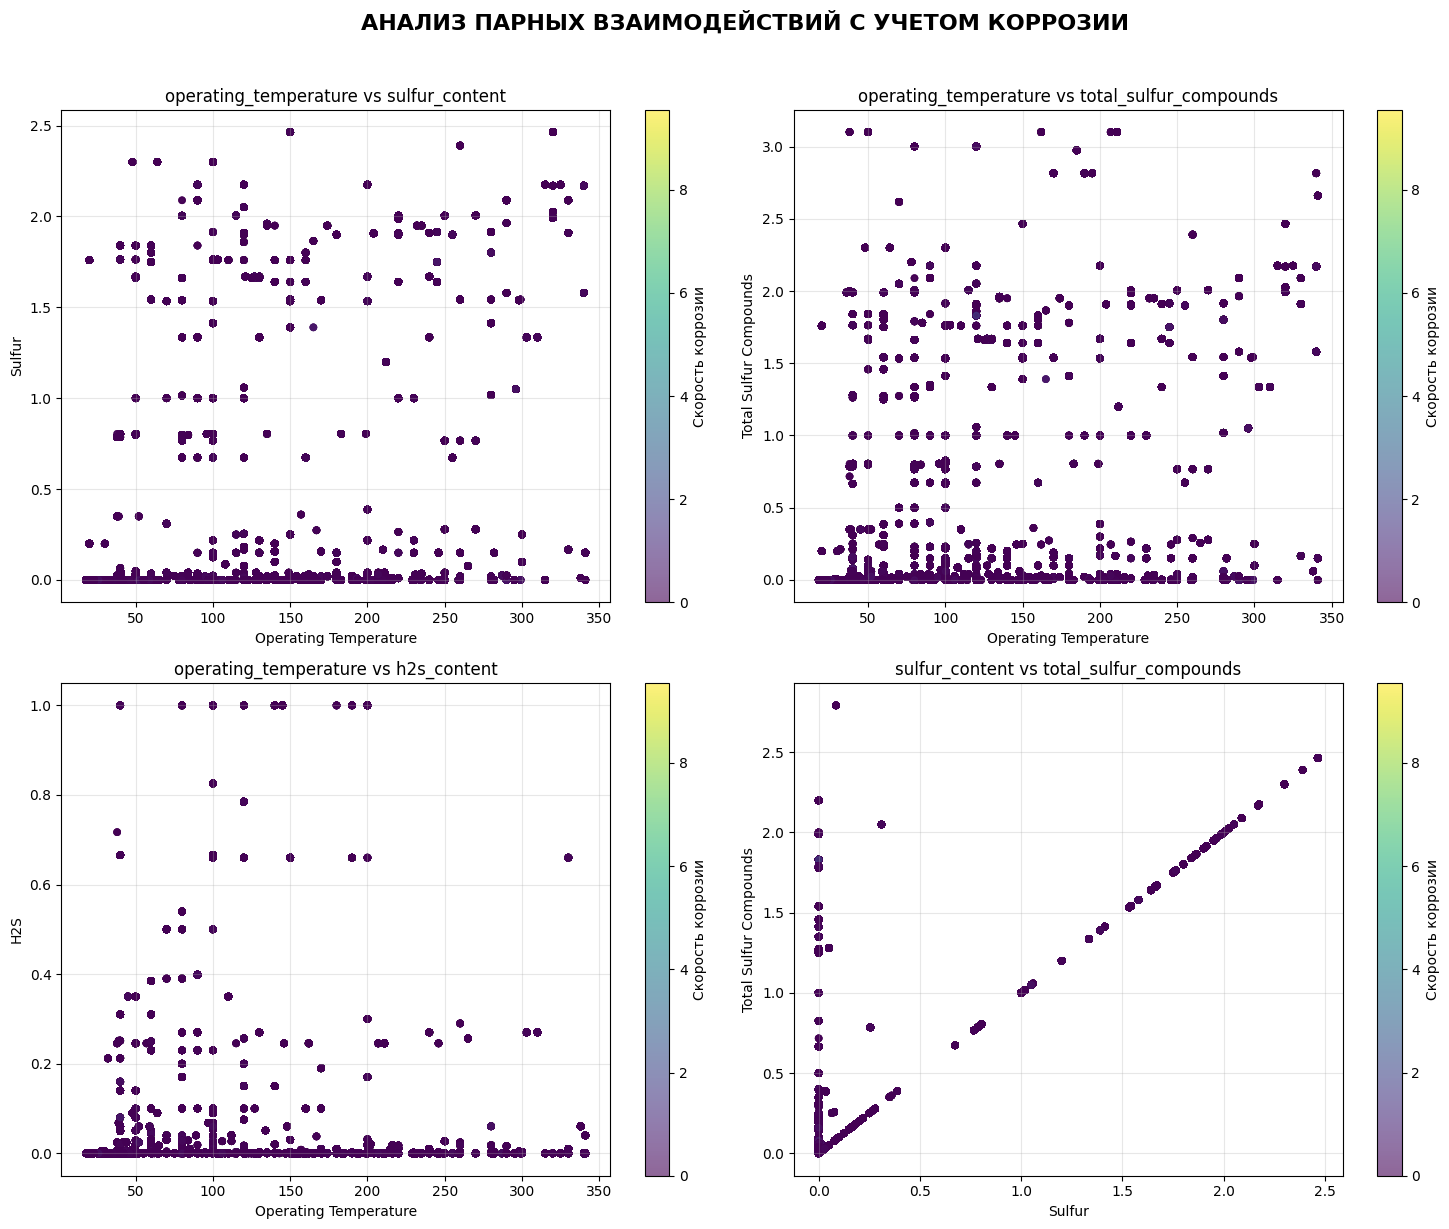

In [26]:
# Ячейка 11: Анализ парных взаимодействий
print("АНАЛИЗ ПАРНЫХ ВЗАИМОДЕЙСТВИЙ:")
print("=" * 70)

# Берем топ-4 параметра по корреляции для анализа
top_corr_params = list(corrosion_correlations.index[1:5])  # Топ-4 кроме corrosion_rate

# Создаем пары для анализа
interesting_pairs = []
for i in range(len(top_corr_params)):
    for j in range(i + 1, len(top_corr_params)):
        interesting_pairs.append((top_corr_params[i], top_corr_params[j]))

# Ограничим количество графиков
interesting_pairs = interesting_pairs[:4]

if interesting_pairs:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, (x_col, y_col) in enumerate(interesting_pairs):
        if i < len(axes) and x_col in df_clean.columns and y_col in df_clean.columns:
            # Берем подвыборку без выбросов для лучшей визуализации
            subset = df_clean[
                (df_clean[x_col] <= df_clean[x_col].quantile(0.95)) & 
                (df_clean[y_col] <= df_clean[y_col].quantile(0.95))
            ]
            
            scatter = axes[i].scatter(subset[x_col], subset[y_col], 
                                    c=subset['corrosion_rate'], 
                                    cmap='viridis', alpha=0.6, s=20)
            axes[i].set_xlabel(x_col.replace('_content', '').replace('_', ' ').title())
            axes[i].set_ylabel(y_col.replace('_content', '').replace('_', ' ').title())
            axes[i].set_title(f'{x_col} vs {y_col}', fontsize=12)
            plt.colorbar(scatter, ax=axes[i], label='Скорость коррозии')
            axes[i].grid(True, alpha=0.3)

    # Убираем лишние subplots
    for i in range(len(interesting_pairs), len(axes)):
        fig.delaxes(axes[i])
        
    plt.suptitle('АНАЛИЗ ПАРНЫХ ВЗАИМОДЕЙСТВИЙ С УЧЕТОМ КОРРОЗИИ', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для парного анализа")

In [27]:
# Ячейка 12: Сохранение результатов и выводы
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ И ВЫВОДЫ:")
print("=" * 70)

# Сохраняем очищенные данные для ML модели
output_path = '../data/corrosion_analysis_cleaned.csv'
df_clean.to_csv(output_path, index=False, encoding='utf-8')

print("✓ ДАННЫЕ СОХРАНЕНЫ:")
print(f"  Файл: {output_path}")
print(f"  Записей: {len(df_clean):,}")
print(f"  Колонок: {len(df_clean.columns)}")

print("\n✓ СТАТИСТИКА ДАННЫХ:")
print(f"  Средняя скорость коррозии: {df_clean['corrosion_rate'].mean():.4f} мм/год")
print(f"  Медианная скорость коррозии: {df_clean['corrosion_rate'].median():.4f} мм/год")
print(f"  Стандартное отклонение: {df_clean['corrosion_rate'].std():.4f} мм/год")
print(f"  Диапазон: [{df_clean['corrosion_rate'].min():.4f}, {df_clean['corrosion_rate'].max():.4f}] мм/год")

print("\n✓ ТОП-ФАКТОРЫ ВЛИЯНИЯ:")
# Берем топ-5 положительных и отрицательных корреляций
top_positive = []
top_negative = []

for param, corr in corrosion_correlations.items():
    if param != 'corrosion_rate':
        if corr > 0:
            top_positive.append((param, corr))
        else:
            top_negative.append((param, corr))

# Сортируем и берем топ-5
top_positive = sorted(top_positive, key=lambda x: x[1], reverse=True)[:5]
top_negative = sorted(top_negative, key=lambda x: x[1])[:5]

print("  Наиболее вероятные УСКОРИТЕЛИ коррозии:")
for i, (factor, corr) in enumerate(top_positive, 1):
    print(f"    {i}. {factor:25} (r = {corr:+.3f})")

print("\n  Наиболее вероятные ЗАМЕДЛИТЕЛИ коррозии:")
for i, (factor, corr) in enumerate(top_negative, 1):
    print(f"    {i}. {factor:25} (r = {corr:+.3f})")

print("\n✓ РЕКОМЕНДАЦИИ ДЛЯ ML МОДЕЛИ:")
print("  1. Использовать топ-15 параметров по корреляции как признаки")
print("  2. Обратить внимание на взаимодействие факторов")
print("  3. Проверить мультиколлинеарность между признаками")
print("  4. Рассмотреть нелинейные преобразования для сильных корреляций")

# Дополнительная информация о данных
print(f"\n✓ ИНФОРМАЦИЯ О ХИМИЧЕСКИХ КОМПОНЕНТАХ:")
chem_cols = [col for col in df_clean.columns if 'content' in col]
if chem_cols:
    non_zero_counts = {}
    for col in chem_cols[:6]:  # Покажем первые 6
        non_zero = (df_clean[col] > 0).sum()
        non_zero_counts[col] = non_zero
    
    print("  Компоненты с ненулевыми значениями:")
    for col, count in list(non_zero_counts.items())[:6]:
        percentage = (count / len(df_clean)) * 100
        print(f"    • {col:25}: {count:4} записей ({percentage:5.1f}%)")

print(f"\n{'='*70}")
print("АНАЛИЗ ЗАВЕРШЕН! Данные готовы для построения ML модели.")
print(f"{'='*70}")

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ И ВЫВОДЫ:
✓ ДАННЫЕ СОХРАНЕНЫ:
  Файл: ../data/corrosion_analysis_cleaned.csv
  Записей: 313,132
  Колонок: 57

✓ СТАТИСТИКА ДАННЫХ:
  Средняя скорость коррозии: 0.0540 мм/год
  Медианная скорость коррозии: 0.0249 мм/год
  Стандартное отклонение: 0.1724 мм/год
  Диапазон: [0.0000, 9.5507] мм/год

✓ ТОП-ФАКТОРЫ ВЛИЯНИЯ:
  Наиболее вероятные УСКОРИТЕЛИ коррозии:
    1. operating_temperature     (r = +0.082)
    2. sulfur_content            (r = +0.076)
    3. total_sulfur_compounds    (r = +0.069)
    4. h2s_content               (r = +0.017)
    5. hydrogen_content          (r = +0.008)

  Наиболее вероятные ЗАМЕДЛИТЕЛИ коррозии:
    1. propylene_content         (r = -0.038)
    2. oxygen_content            (r = -0.027)
    3. nitrogen_content          (r = -0.023)
    4. ethylene_content          (r = -0.021)
    5. water_content             (r = -0.020)

✓ РЕКОМЕНДАЦИИ ДЛЯ ML МОДЕЛИ:
  1. Использовать топ-15 параметров по корреляции как признаки
  2. Обратить вни

In [30]:
# Исправление предупреждения и углубленный анализ
print("УГЛУБЛЕННЫЙ АНАЛИЗ С УЧЕТОМ НОВЫХ ДАННЫХ:")
print("=" * 70)

# 1. Исправляем группировку
temp_corrosion = df_clean.groupby('temp_range', observed=False)['corrosion_rate'].mean()
print("1. КОРРОЗИЯ ПО ТЕМПЕРАТУРАМ (исправлено):")
for temp_range, corr_rate in temp_corrosion.items():
    print(f"   • {temp_range}: {corr_rate:.4f} мм/год")

# 2. Анализ экстремальных случаев
print("\n2. ДЕТАЛЬНЫЙ АНАЛИЗ ВЫСОКОЙ КОРРОЗИИ:")
high_corr_detail = df_clean[df_clean['corrosion_rate'] > 1.0]

if len(high_corr_detail) > 0:
    print(f"   • Доля от общего объема: {len(high_corr_detail)/len(df_clean)*100:.2f}%")
    print(f"   • Максимальная скорость: {high_corr_detail['corrosion_rate'].max():.2f} мм/год")
    
    # Анализ химического состава в экстремальных случаях
    chem_analysis = high_corr_detail[['h2s_content', 'sulfur_content', 'water_content']].mean()
    print(f"   • Средний состав в экстремальных случаях:")
    print(f"     - H2S: {chem_analysis['h2s_content']:.4f}%")
    print(f"     - Сера: {chem_analysis['sulfur_content']:.4f}%")
    print(f"     - Вода: {chem_analysis['water_content']:.4f}%")

# 3. Анализ взаимодействия факторов
print("\n3. АНАЛИЗ ВЗАИМОДЕЙСТВИЯ ФАКТОРОВ:")
print("   КРИТИЧЕСКИЕ КОМБИНАЦИИ:")

# Комбинация температура + H2S
high_temp_h2s = df_clean[
    (df_clean['operating_temperature'] > 150) & 
    (df_clean['h2s_content'] > 0.1)
]
if len(high_temp_h2s) > 0:
    print(f"   • Температура >150°C + H2S >0.1%: {len(high_temp_h2s)} случаев")
    print(f"     Средняя коррозия: {high_temp_h2s['corrosion_rate'].mean():.4f} мм/год")

# Комбинация температура + сера
high_temp_sulfur = df_clean[
    (df_clean['operating_temperature'] > 150) & 
    (df_clean['sulfur_content'] > 1.0)
]
if len(high_temp_sulfur) > 0:
    print(f"   • Температура >150°C + Сера >1.0%: {len(high_temp_sulfur)} случаев")
    print(f"     Средняя коррозия: {high_temp_sulfur['corrosion_rate'].mean():.4f} мм/год")

УГЛУБЛЕННЫЙ АНАЛИЗ С УЧЕТОМ НОВЫХ ДАННЫХ:
1. КОРРОЗИЯ ПО ТЕМПЕРАТУРАМ (исправлено):
   • 0-50°C: 0.0401 мм/год
   • 50-100°C: 0.0448 мм/год
   • 100-150°C: 0.0650 мм/год
   • 150-200°C: 0.0673 мм/год
   • 200-300°C: 0.0588 мм/год
   • 300+°C: 0.1049 мм/год

2. ДЕТАЛЬНЫЙ АНАЛИЗ ВЫСОКОЙ КОРРОЗИИ:
   • Доля от общего объема: 0.68%
   • Максимальная скорость: 9.55 мм/год
   • Средний состав в экстремальных случаях:
     - H2S: 0.3186%
     - Сера: 1.2997%
     - Вода: 2.3792%

3. АНАЛИЗ ВЗАИМОДЕЙСТВИЯ ФАКТОРОВ:
   КРИТИЧЕСКИЕ КОМБИНАЦИИ:
   • Температура >150°C + H2S >0.1%: 7271 случаев
     Средняя коррозия: 0.0940 мм/год
   • Температура >150°C + Сера >1.0%: 31865 случаев
     Средняя коррозия: 0.1001 мм/год
